In [1]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/paper_5/cm_hinglish_f.csv')

In [2]:
data_text = data['text']
data_label = data['label']

In [3]:
 import numpy as np
 from sklearn.model_selection import train_test_split
 train, test, labels_train, labels_test = train_test_split(data_text, data_label, test_size=0.20, random_state=42 )

In [4]:
import numpy as np
from keras.utils.np_utils import to_categorical
#classes_list = ["ham","spam"]
#label_index = class_label.apply(classes_list.index)
label_train = to_categorical(np.asarray(labels_train))
label_test = to_categorical(np.asarray(labels_test))

In [5]:
from keras.preprocessing.text import Tokenizer
tk=Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ")
tk.fit_on_texts(train)
index=tk.word_index
print(index)
x = tk.texts_to_sequences(train)
x1 = tk.texts_to_sequences(test)
print (x)
vocab_size = len(index)
word_index = tk.word_index

{'hai': 1, 'ki': 2, 'ko': 3, 'politics': 4, 'ke': 5, 'bhi': 6, 'se': 7, 'to': 8, 'cricket': 9, 'aur': 10, 'ka': 11, 'ho': 12, 'talaq': 13, 'nahi': 14, 'me': 15, 'triple': 16, 'k': 17, 'ye': 18, 'hi': 19, 'bollywood': 20, 'kar': 21, 'hain': 22, 'aap': 23, 'kya': 24, 'liye': 25, 'kuch': 26, 'koi': 27, 'jo': 28, 'par': 29, 'h': 30, 'bhai': 31, 'na': 32, 'ek': 33, 'irony': 34, 'ne': 35, 'ab': 36, 'rahe': 37, 'twitter': 38, 'mein': 39, 'log': 40, 'com': 41, 'sarcasm': 42, 'pe': 43, 'tripletalaq': 44, 'he': 45, 'aaj': 46, 'is': 47, 'raha': 48, 'nhi': 49, 'baat': 50, 'desh': 51, 'ji': 52, 'tha': 53, 'sab': 54, 'or': 55, 'toh': 56, 'sir': 57, 'main': 58, 'wo': 59, 'gaya': 60, 'hota': 61, 'mai': 62, 'karte': 63, 'apni': 64, 'abhi': 65, 'tum': 66, 'modi': 67, 'apne': 68, 'rahi': 69, 'pic': 70, 'in': 71, 'tu': 72, 'muslim': 73, 'kabhi': 74, 'kiya': 75, 'jab': 76, 'pakistan': 77, 'sirf': 78, 'the': 79, 'chahiye': 80, 'de': 81, 'jaise': 82, 'aa': 83, 'do': 84, 'karne': 85, 'diya': 86, 'hoga': 87, '

In [6]:
from keras.preprocessing.sequence import pad_sequences
embedding_vecor_length =32
padded_docs_train = pad_sequences(x, maxlen=embedding_vecor_length, padding='post')
padded_docs_test = pad_sequences(x1, maxlen=embedding_vecor_length, padding='post')

In [7]:
#load pre-trained embedding:
embeddings_index = {}
f = open('/content/drive/My Drive/LSTM_Attention_on_sarcasm_dataset/glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:], dtype='float32') # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1193514 word vectors in Glove 6B 100d.


In [8]:
# Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 100
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#embedding_matrix = (16433, 100) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word) # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           1415200   
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

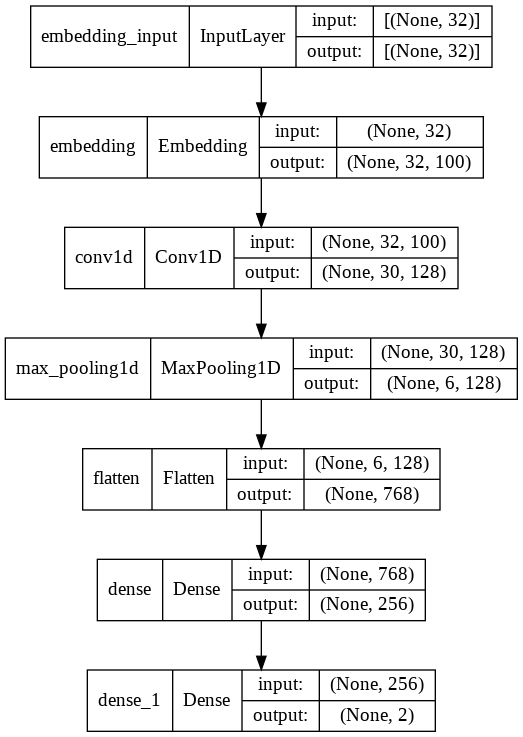

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, weights=[embedding_matrix], input_length=embedding_vecor_length, trainable=False))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [10]:
model.fit(padded_docs_train, label_train, validation_data = (padded_docs_test, label_test),
          epochs=10,batch_size=100, verbose=2)

Epoch 1/10
42/42 - 4s - loss: 0.3187 - accuracy: 0.8974 - val_loss: 0.3145 - val_accuracy: 0.8838 - 4s/epoch - 97ms/step
Epoch 2/10
42/42 - 2s - loss: 0.2258 - accuracy: 0.9119 - val_loss: 0.2006 - val_accuracy: 0.9248 - 2s/epoch - 40ms/step
Epoch 3/10
42/42 - 2s - loss: 0.1305 - accuracy: 0.9467 - val_loss: 0.1204 - val_accuracy: 0.9590 - 2s/epoch - 37ms/step
Epoch 4/10
42/42 - 2s - loss: 0.0938 - accuracy: 0.9605 - val_loss: 0.1113 - val_accuracy: 0.9590 - 2s/epoch - 38ms/step
Epoch 5/10
42/42 - 1s - loss: 0.0694 - accuracy: 0.9736 - val_loss: 0.1305 - val_accuracy: 0.9371 - 1s/epoch - 34ms/step
Epoch 6/10
42/42 - 1s - loss: 0.0476 - accuracy: 0.9848 - val_loss: 0.1307 - val_accuracy: 0.9429 - 1s/epoch - 35ms/step
Epoch 7/10
42/42 - 1s - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.1428 - val_accuracy: 0.9419 - 924ms/epoch - 22ms/step
Epoch 8/10
42/42 - 1s - loss: 0.0156 - accuracy: 0.9971 - val_loss: 0.1461 - val_accuracy: 0.9448 - 940ms/epoch - 22ms/step
Epoch 9/10
42/42 - 1s - lo

In [11]:
predictions_test_cnn = model.predict(padded_docs_test)
predictions_testcnn1 = np.zeros_like(predictions_test_cnn)
predictions_testcnn1[np.arange(len(predictions_test_cnn)), predictions_test_cnn.argmax(1)] = 1
from sklearn.metrics import classification_report
print('CNN')
print(classification_report(label_test,predictions_testcnn1))


CNN
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       928
           1       0.87      0.70      0.77       122

   micro avg       0.95      0.95      0.95      1050
   macro avg       0.91      0.84      0.87      1050
weighted avg       0.95      0.95      0.95      1050
 samples avg       0.95      0.95      0.95      1050

